In [5]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor

# Modelos de Machine Learning e Deep Learning
# 📊SVR
#### 💾 Carregamento e preparação da série temporal

In [58]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Função para montar o design-matrix a partir de DateTime + colunas originais
def create_features(df):
    X = pd.DataFrame({
        "Hour": df["Hour"],
        "Temperature": df["Temperature"]
    })

    # mapeia TimeOfDay para ordinal
    tod_map = {"Manhã":0, "Tarde":1, "Noite":2}
    X["TimeOfDay"] = df["TimeOfDay"].map(tod_map).fillna(0).astype(int)

    # mapeia DayOfTheWeek para ordinal
    dofw_map = {"Segunda":0, "Terça":1, "Quarta":2, "Quinta":3, "Sexta":4, "Sábado":5, "Domingo":6}
    X["DayOfTheWeek"] = df["DayOfTheWeek"].map(dofw_map).fillna(0).astype(int)

    return X

#### ✂️ Split treino/teste

In [59]:
train_df = df_cp[df_cp["DateTime"] < "2023-09-30"]
test_df  = df_cp[
    (df_cp["DateTime"] >= "2023-09-30") &
    (df_cp["DateTime"] <  "2023-10-01")
]

X_train = create_features(train_df)
y_train = train_df["EnergyNormalized"].to_numpy()
X_test  = create_features(test_df)
y_test  = test_df["EnergyNormalized"].to_numpy()

In [60]:
# Escala features
# 1) Escolha as colunas a escalar
cols_to_scale = ["Hour", "Temperature"]

# 2) Crie o scaler e ajuste só no treino
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

# 3) Aplique a transformação somente nessas colunas
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

#### 💾 Carregamento do modelo

In [61]:
# (Opcional) Carrega um modelo previamente treinado.
pipeline = load("predicts/SVR/modelo/SVR_pipeline.joblib")

#### 🛠️ Treinar

In [46]:
pipeline = Pipeline([
    ("scaler", ColumnTransformer([
        ("hour_temp", StandardScaler(), ["Hour", "Temperature"])
    ], remainder="passthrough")),  # as outras colunas passam sem alteração
    ("svr", SVR(kernel="rbf", C=10.0, epsilon=0.01))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

dump(pipeline, "predicts/SVR/modelo/SVR_pipeline.joblib") # Guarda o modelo treinado.

['predicts/SVR/modelo/SVR_pipeline.joblib']

#### 📈 Previsão e avaliação

In [62]:
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_test - y_pred) / y_test)*100).mean()

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.2f}%")

MAE:  0.00543
MSE:  0.00004
RMSE: 0.00601
MAPE: 11.54%


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                                                                  |
|----------------------------------------------|---------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00543 | O erro médio absoluto é bastante baixo, o que indica que as previsões do SVR, em média, diferem pouco dos valores reais. Um bom resultado para previsão horária.                               |
| **MSE** (Erro Quadrático Médio)              | 0.00004 | Um MSE extremamente baixo mostra que grandes desvios são raros, o que indica boa estabilidade do modelo mesmo nas zonas com variações mais acentuadas.                                         |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00601 | Representa o erro médio esperado com a mesma unidade da variável alvo. Um RMSE em torno de 0.006 indica que o SVR está a prever com boa precisão geral.                                        |
| **MAPE** (Erro Percentual Absoluto Médio)    | 11.54%  | Um erro percentual de 11.5% é bastante aceitável em séries temporais de consumo energético, embora inferior ao XARIMA (5.55%), é significativamente melhor que ARIMA puro ou Regressão Linear. |

#### 🖼️ Visualização gráfica

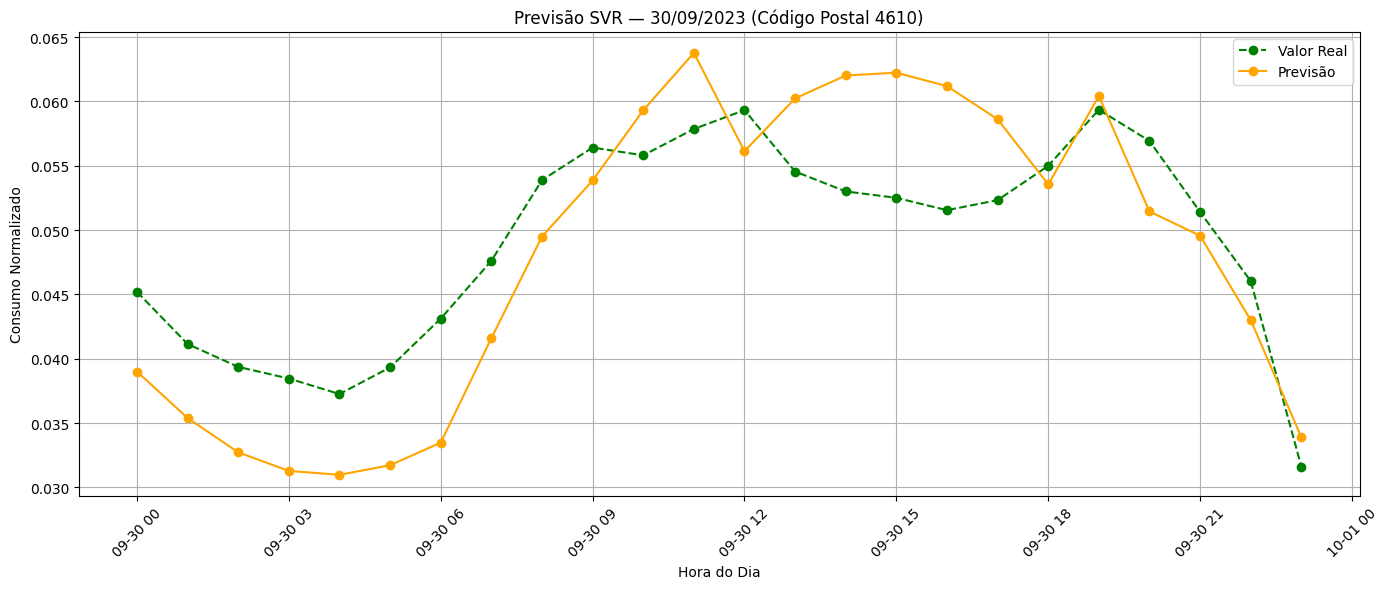

In [63]:
timestamps = test_df["DateTime"]

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_test, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão SVR — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/SVR/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊RF
#### 💾 Carregamento e preparação da série temporal

In [3]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Função para montar o design-matrix a partir de DateTime + colunas originais
def create_features(df):
    X = pd.DataFrame({
        "Hour": df["Hour"],
        "Temperature": df["Temperature"]
    })

    # mapeia TimeOfDay para ordinal
    tod_map = {"Manhã":0, "Tarde":1, "Noite":2}
    X["TimeOfDay"] = df["TimeOfDay"].map(tod_map).fillna(0).astype(int)

    # mapeia DayOfTheWeek para ordinal
    dofw_map = {"Segunda":0, "Terça":1, "Quarta":2, "Quinta":3, "Sexta":4, "Sábado":5, "Domingo":6}
    X["DayOfTheWeek"] = df["DayOfTheWeek"].map(dofw_map).fillna(0).astype(int)

    return X

#### ✂️ Split treino/teste

In [4]:
train_df = df_cp[df_cp["DateTime"] < "2023-09-30"]
test_df  = df_cp[
    (df_cp["DateTime"] >= "2023-09-30") &
    (df_cp["DateTime"] <  "2023-10-01")
]

X_train = create_features(train_df)
y_train = train_df["EnergyNormalized"].to_numpy()
X_test  = create_features(test_df)
y_test  = test_df["EnergyNormalized"].to_numpy()

In [6]:
# Escala features
# 1) Escolha as colunas a escalar
cols_to_scale = ["Hour", "Temperature"]

# 2) Crie o scaler e ajuste só no treino
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

# 3) Aplique a transformação somente nessas colunas
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

#### 💾 Carregamento do modelo

In [ ]:
# (Opcional) Carrega um modelo previamente treinado.
pipeline = load("predicts/RF/modelo/RF_pipeline.joblib")

#### 🛠️ Treinar

In [8]:
pipeline = Pipeline([
    ("scaler", ColumnTransformer([
        ("hour_temp", StandardScaler(), ["Hour", "Temperature"])
    ], remainder="passthrough")),  # as outras colunas passam sem alteração
    ("rf", RandomForestRegressor(n_estimators=100, random_state=123, n_jobs=-1))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

dump(pipeline, "predicts/RF/modelo/RF_pipeline.joblib") # Guarda o modelo treinado.

['predicts/RF/modelo/RF_pipeline.joblib']

#### 📈 Previsão e avaliação

In [9]:
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_test - y_pred) / y_test)*100).mean()

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.2f}%")

MAE:  0.00337
MSE:  0.00002
RMSE: 0.00438
MAPE: 7.55%


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação |
|----------------------------------------------|---------|---------------|
| **MAE** (Erro Absoluto Médio)                | 0.00337 | a             |
| **MSE** (Erro Quadrático Médio)              | 0.00002 | a             |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00438 | a             |
| **MAPE** (Erro Percentual Absoluto Médio)    | 7.55%   | a             |

#### 🖼️ Visualização gráfica

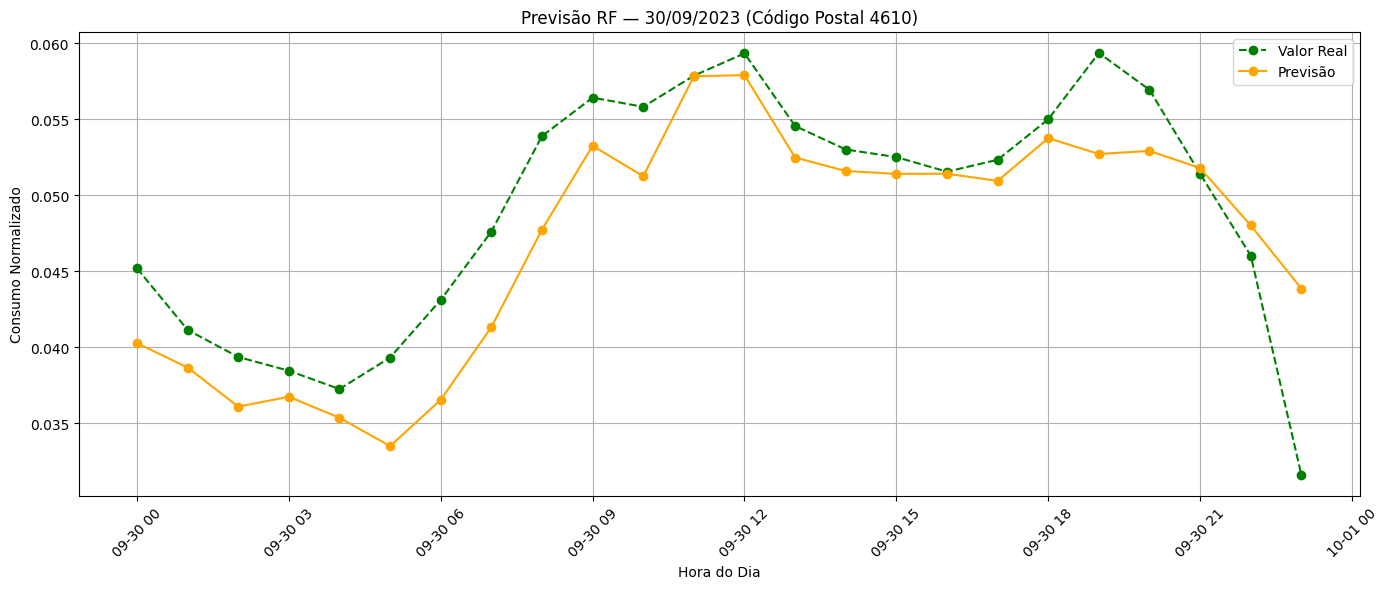

In [10]:
timestamps = test_df["DateTime"]

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_test, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão RF — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/RF/grafico.png", dpi=300, bbox_inches='tight')
plt.show()